In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import seaborn as sns

In [ ]:
def summarize_missing(df, title="缺失值統計", max_rows=30):
    print(f"\n▶ {title}")
    na = df.isna().sum()
    na = na[na > 0].sort_values(ascending=False)
    if na.empty:
        print("   無缺失值")
    else:
        print(na.head(max_rows).to_string())
        if len(na) > max_rows:
            print(f"  ... 另有 {len(na) - max_rows} 欄省略")

In [3]:
def minmax(s: pd.Series) -> pd.Series:
    s = pd.to_numeric(s, errors="coerce")
    mn, mx = s.min(skipna=True), s.max(skipna=True)
    if pd.isna(mn) or pd.isna(mx) or mn == mx:
        return pd.Series(np.zeros(len(s), dtype=float), index=s.index)
    return (s - mn) / (mx - mn)

In [4]:
def mood_category(v):
    if pd.isna(v):
        return np.nan
    elif v < 0.33:
        return 'Sad / Negative'
    elif v < 0.66:
        return 'Neutral / Moderate'
    else:
        return 'Happy / Positive'

In [5]:
def balanced_sample_per_mood(d: pd.DataFrame, mood_col: str, n: int, value_cols, seed: int = 42):
    """
    對 d 依 mood_col 分組，每組最多取 n 筆樣本。
    value_cols 可為字串或字串列表；會一併保留。
    使用「隨機排序 + groupby().head(n)」，避免 apply 棄用警告。
    """
    if isinstance(value_cols, str):
        keep_cols = [mood_col, value_cols]
    else:
        keep_cols = [mood_col] + list(value_cols)

    rng = np.random.default_rng(seed)
    out = d[keep_cols].copy()
    out["__rand"] = rng.random(len(out))
    out = (
        out.sort_values("__rand")
           .groupby(mood_col, group_keys=False)
           .head(n)
           .drop(columns="__rand")
    )
    return out

In [6]:
def impute_likes_and_stream(df: pd.DataFrame) -> pd.DataFrame:
    """
    Likes：以 mean(likes/views) 估補（views>0，有限值）
    Stream：以每位 Artist 的 median(stream/views) 估補；無對應者用全域中位數
    """
    # 型別
    for c in ["Likes", "Views", "Stream", "Valence"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    if "Url_youtube" in df.columns:
        df["Url_youtube"] = df["Url_youtube"].astype("string")

    summarize_missing(df, "前置處理後缺失值")

    # ---- Likes by like/view ratio
    mask_ratio = df["Likes"].notna() & df["Views"].gt(0)
    tmp = df.loc[mask_ratio, ["Likes", "Views"]].copy()
    tmp["like_view_ratio"] = tmp["Likes"] / tmp["Views"]
    like_view_ratio = tmp.loc[np.isfinite(tmp["like_view_ratio"]), "like_view_ratio"].mean()

    print(f"\n估計的 like_view_ratio = {like_view_ratio:.6f}")
    cond_like = df["Likes"].isna() & df["Views"].gt(0)  # 需要可改成 & df["Url_youtube"].notna()
    df.loc[cond_like, "Likes"] = df.loc[cond_like, "Views"] * like_view_ratio
    df["Likes"] = df["Likes"].round().astype("Int64")
    print(f"→ 依比例補 Likes 筆數：{int(cond_like.sum())}")

    # ---- Stream by artist-level median(stream/views)
    g = df.loc[df["Stream"].notna() & df["Views"].gt(0), ["Artist", "Stream", "Views"]].copy()
    g["sv_ratio"] = g["Stream"] / g["Views"]
    sv = g.loc[np.isfinite(g["sv_ratio"]), ["Artist", "sv_ratio"]]
    artist_ratio = sv.groupby("Artist")["sv_ratio"].median()
    global_ratio = sv["sv_ratio"].median()
    print(f"全域 Stream/Views 中位比例 = {global_ratio:.6f}")

    cond_stream = df["Stream"].isna() & df["Views"].gt(0)
    to_fill = df.loc[cond_stream, ["Artist", "Views"]].copy()
    to_fill["ratio"] = to_fill["Artist"].map(artist_ratio).fillna(global_ratio)
    df.loc[cond_stream, "Stream"] = (to_fill["Views"] * to_fill["ratio"]).round()
    df["Stream"] = pd.to_numeric(df["Stream"], errors="coerce").astype("Int64")
    print(f"→ 依藝人比例補 Stream 筆數：{int(cond_stream.sum())}")

    summarize_missing(df, "補值後缺失值")
    return df

In [ ]:
# 1) 讀檔與補值
csv_path = r"C:\Users\hu041\OneDrive\桌面\nschool\Spotify_Youtube.csv"  
df = pd.read_csv(csv_path)
df = impute_likes_and_stream(df)


▶ 前置處理後缺失值
Description         876
Stream              576
Comments            569
Likes               541
Url_youtube         470
Licensed            470
official_video      470
Views               470
Channel             470
Title               470
Danceability          2
Key                   2
Energy                2
Speechiness           2
Loudness              2
Tempo                 2
Duration_ms           2
Instrumentalness      2
Acousticness          2
Liveness              2
Valence               2

估計的 like_view_ratio = 0.012249
→ 依比例補 Likes 筆數：71
全域 Stream/Views 中位比例 = 3.158846
→ 依藝人比例補 Stream 筆數：555

▶ 補值後缺失值
Description         876
Comments            569
Url_youtube         470
Title               470
Channel             470
official_video      470
Views               470
Licensed            470
Likes               470
Stream               21
Danceability          2
Key                   2
Energy                2
Speechiness           2
Loudness              2
Tempo   

In [8]:
# 2) 正規化與 Valence 分箱曲線（各平台）
# 數值/對數
for c in ["Valence", "Stream", "Views"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

df["log_Stream"] = np.log1p(df["Stream"])
df["log_Views"]  = np.log1p(df["Views"])
# 分箱（0~1 切 10 等份）
bins   = np.linspace(0, 1, 11)
labels = [f"{b:.1f}-{b+0.1:.1f}" for b in bins[:-1]]
df["valence_group"] = pd.cut(df["Valence"], bins=bins, labels=labels, include_lowest=True)

# 平台內部 Min–Max 正規化
df["norm_Stream"] = minmax(df["log_Stream"])
df["norm_Views"]  = minmax(df["log_Views"])

In [9]:
# 各平台曲線
spotify_v_trend = (
    df.groupby("valence_group", observed=True)["norm_Stream"].mean().reset_index()
)
youtube_v_trend = (
    df.groupby("valence_group", observed=True)["norm_Views"].mean().reset_index()
)

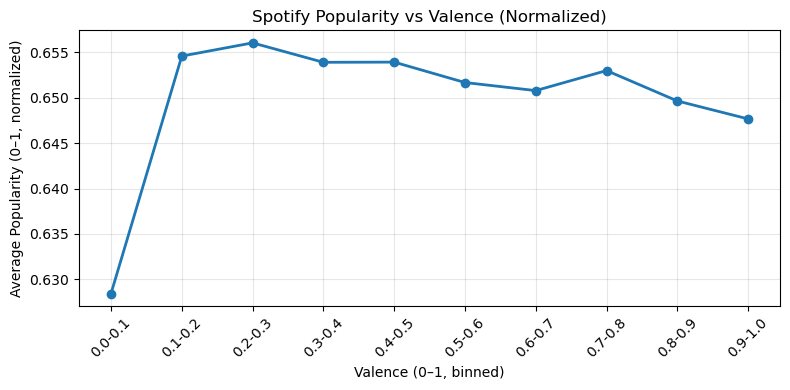

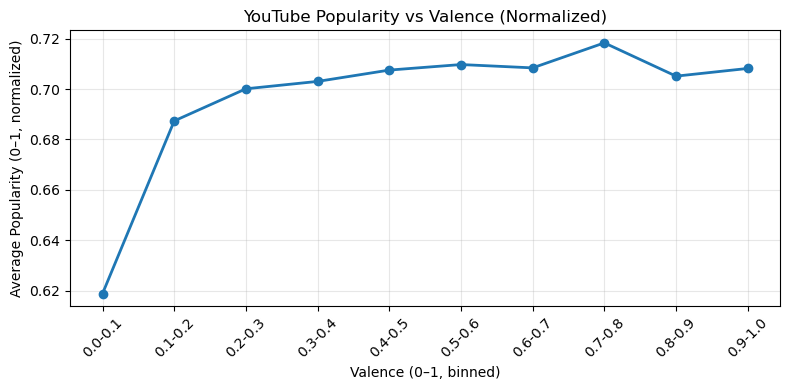

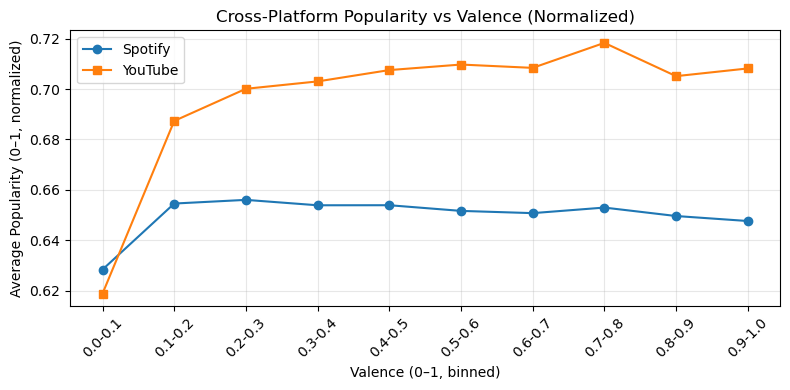

In [10]:
plt.figure(figsize=(8,4))
plt.plot(spotify_v_trend["valence_group"], spotify_v_trend["norm_Stream"], marker="o", linewidth=2)
plt.title("Spotify Popularity vs Valence (Normalized)")
plt.xlabel("Valence (0–1, binned)")
plt.ylabel("Average Popularity (0–1, normalized)")
plt.grid(True, alpha=0.3); plt.xticks(rotation=45)
plt.tight_layout(); plt.show()

plt.figure(figsize=(8,4))
plt.plot(youtube_v_trend["valence_group"], youtube_v_trend["norm_Views"], marker="o", linewidth=2)
plt.title("YouTube Popularity vs Valence (Normalized)")
plt.xlabel("Valence (0–1, binned)")
plt.ylabel("Average Popularity (0–1, normalized)")
plt.grid(True, alpha=0.3); plt.xticks(rotation=45)
plt.tight_layout(); plt.show()

plt.figure(figsize=(8,4))
plt.plot(spotify_v_trend["valence_group"], spotify_v_trend["norm_Stream"], marker="o", label="Spotify")
plt.plot(youtube_v_trend["valence_group"], youtube_v_trend["norm_Views"], marker="s", label="YouTube")
plt.title("Cross-Platform Popularity vs Valence (Normalized)")
plt.xlabel("Valence (0–1, binned)")
plt.ylabel("Average Popularity (0–1, normalized)")
plt.legend(); plt.grid(True, alpha=0.3); plt.xticks(rotation=45)
plt.tight_layout(); plt.show()


Spotify 抽樣分佈：
Mood
Happy / Positive      2500
Neutral / Moderate    2500
Sad / Negative        2500

YouTube 抽樣分佈：
Mood
Neutral / Moderate    2500
Happy / Positive      2500
Sad / Negative        2500


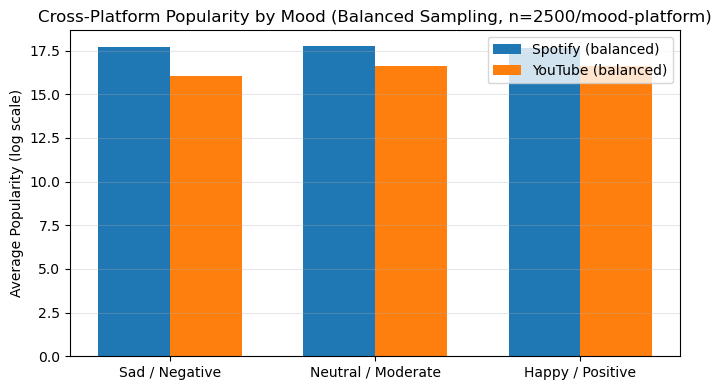

In [11]:
# 3) 等量抽樣（按情緒） + 三類情緒對比
df["Mood"] = df["Valence"].apply(mood_category)
moods = ["Sad / Negative","Neutral / Moderate","Happy / Positive"]

# 建平台子表
spotify_df = df.loc[df["log_Stream"].notna() & df["Mood"].notna(), ["Mood","log_Stream"]].copy()
youtube_df = df.loc[df["log_Views"].notna()  & df["Mood"].notna(), ["Mood","log_Views"] ].copy()

target_n = 2500  # 每平台每情緒最多抽樣數（不足時取能抽到的最大值）
spotify_bal = balanced_sample_per_mood(spotify_df, "Mood", target_n, "log_Stream", seed=42)
youtube_bal = balanced_sample_per_mood(youtube_df, "Mood", target_n, "log_Views",  seed=42)

print("\nSpotify 抽樣分佈："); print(spotify_bal["Mood"].value_counts().to_string())
print("\nYouTube 抽樣分佈："); print(youtube_bal["Mood"].value_counts().to_string())

# 以「中位數」更抗極端值（也可改 mean）
spotify_bal_summary = spotify_bal.groupby("Mood")["log_Stream"].median().reindex(moods)
youtube_bal_summary = youtube_bal.groupby("Mood")["log_Views" ].median().reindex(moods)

x = np.arange(len(moods)); width = 0.35
plt.figure(figsize=(7,4))
plt.bar(x - width/2, spotify_bal_summary.values, width, label="Spotify (balanced)")
plt.bar(x + width/2, youtube_bal_summary.values, width, label="YouTube (balanced)")
plt.xticks(x, moods); plt.ylabel("Average Popularity (log scale)")
plt.title(f"Cross-Platform Popularity by Mood (Balanced Sampling, n={target_n}/mood-platform)")
plt.legend(); plt.grid(axis="y", alpha=0.3); plt.tight_layout(); plt.show()

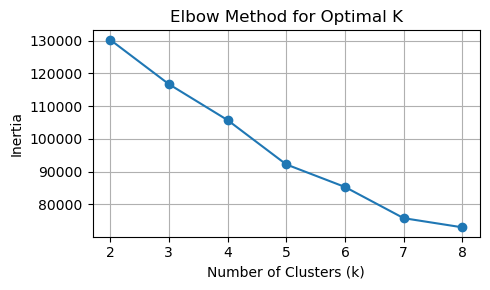

In [12]:
# 4) K-Means 分群（以 Spotify 音訊特徵）
features = [
    "Danceability","Energy","Speechiness","Acousticness",
    "Instrumentalness","Liveness","Valence","Tempo"
]
for c in features:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

df_cluster = df[features + ["Artist","Track","Stream","Views"]].dropna().copy()

# Z-score 標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster[features])

# Elbow：選 k
inertia = []
K_range = range(2, 9)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(5,3))
plt.plot(list(K_range), inertia, marker="o")
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (k)"); plt.ylabel("Inertia")
plt.grid(True); plt.tight_layout(); plt.show()

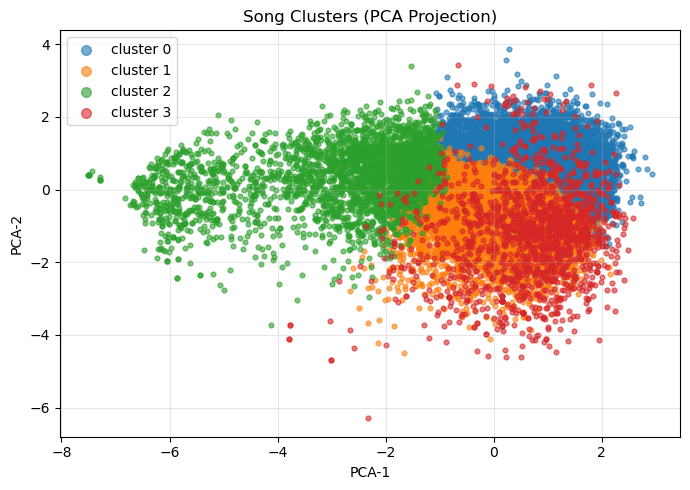

In [13]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
df_cluster["cluster"] = kmeans.fit_predict(X_scaled)

# PCA 2D 投影
pca = PCA(n_components=2)
p2 = pca.fit_transform(X_scaled)
df_cluster["pca1"] = p2[:,0]; df_cluster["pca2"] = p2[:,1]

plt.figure(figsize=(7,5))
for cid in sorted(df_cluster["cluster"].unique()):
    sub = df_cluster[df_cluster["cluster"] == cid]
    plt.scatter(sub["pca1"], sub["pca2"], s=12, alpha=0.6, label=f"cluster {cid}")
plt.title("Song Clusters (PCA Projection)")
plt.xlabel("PCA-1"); plt.ylabel("PCA-2")
plt.legend(markerscale=2); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()


各群平均音樂特徵：
         Danceability  Energy  Speechiness  Acousticness  Instrumentalness  Liveness  Valence    Tempo
cluster                                                                                               
0               0.734   0.686        0.113         0.237             0.014     0.148    0.697  115.500
1               0.544   0.705        0.076         0.143             0.035     0.166    0.400  133.426
2               0.460   0.299        0.046         0.752             0.237     0.141    0.292  109.153
3               0.598   0.717        0.175         0.271             0.024     0.625    0.563  120.169

各群平均人氣 (log scale)：
         Stream   Views
cluster                
0        18.906  18.544
1        19.135  18.338
2        18.516  17.665
3        18.652  18.256


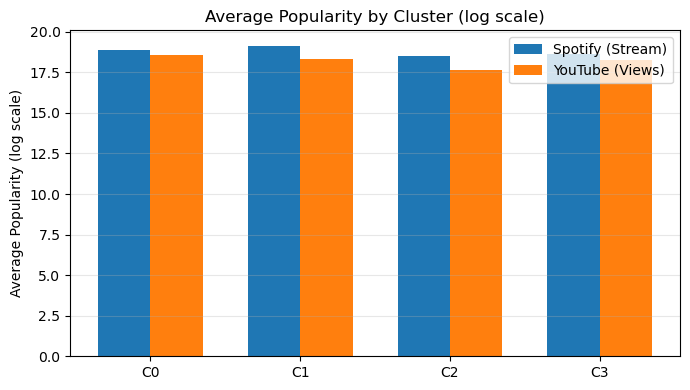

In [14]:
# 各群平均特徵
cluster_features = df_cluster.groupby("cluster")[features].mean().round(3)
print("\n各群平均音樂特徵：")
print(cluster_features.to_string())

# 各群在兩平台的人氣（log1p 平均），觀察哪類在何平台更紅
cluster_pop = (
    df_cluster.groupby("cluster")[["Stream","Views"]]
              .mean()
              .pipe(np.log1p)
              .round(3)
)
print("\n各群平均人氣 (log scale)：")
print(cluster_pop.to_string())

plt.figure(figsize=(7,4))
x = np.arange(k); width = 0.35
plt.bar(x - width/2, cluster_pop["Stream"].values, width, label="Spotify (Stream)")
plt.bar(x + width/2, cluster_pop["Views"].values,  width, label="YouTube (Views)")
plt.xticks(x, [f"C{cid}" for cid in range(k)])
plt.ylabel("Average Popularity (log scale)")
plt.title("Average Popularity by Cluster (log scale)")
plt.legend(); plt.grid(axis="y", alpha=0.3); plt.tight_layout(); plt.show()


🎧 Spotify 各群平均特徵：
            Danceability  Energy  Speechiness  Acousticness  Instrumentalness  Liveness  Valence    Tempo
cluster_sp                                                                                               
0                  0.657   0.748        0.068         0.155             0.019     0.204    0.621  123.502
1                  0.533   0.440        0.049         0.551             0.014     0.170    0.374  115.630
2                  0.377   0.298        0.049         0.691             0.825     0.150    0.219  108.484
3                  0.716   0.650        0.328         0.235             0.006     0.207    0.551  122.555

📺 YouTube 各群平均特徵：
            Danceability  Energy  Speechiness  Acousticness  Instrumentalness  Liveness  Valence    Tempo
cluster_yt                                                                                               
0                  0.736   0.694        0.128         0.202             0.013     0.149    0.672  115.288
1       

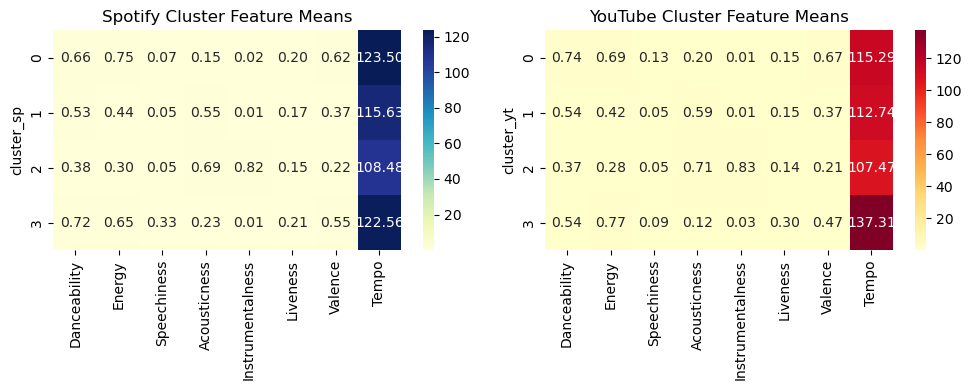

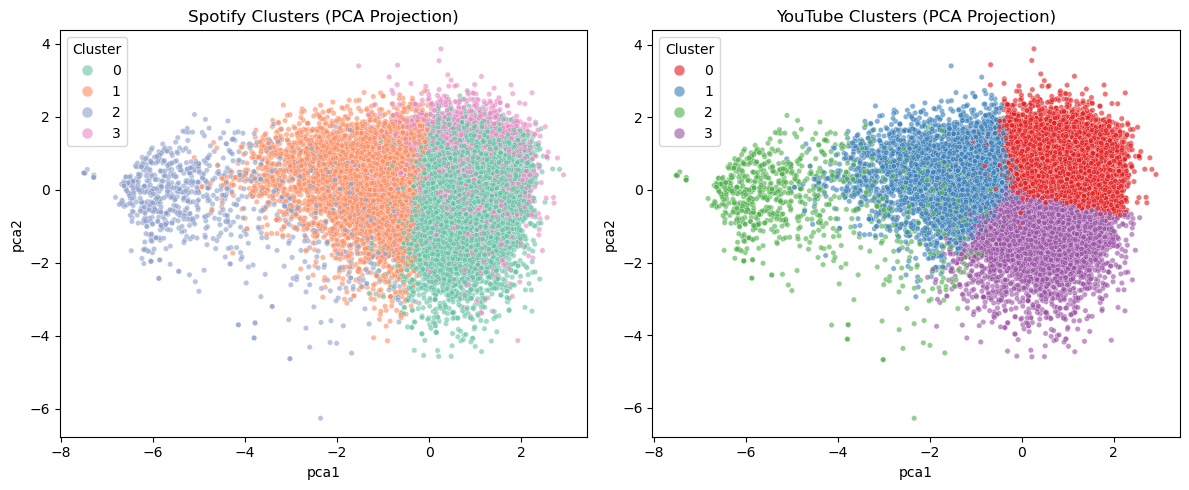

In [ ]:
# 5) 兩平台各自的分群 (Spotify vs YouTube)
# ---- 選取共通音樂特徵 ----
features = [
    "Danceability","Energy","Speechiness","Acousticness",
    "Instrumentalness","Liveness","Valence","Tempo"
]

# 確保特徵為數值（非數字轉 NaN，待補值）
for c in features:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# ---- Spotify 分群資料（僅要求有 Stream；特徵缺失用中位數補）----
spotify_cluster = df[features + ["Stream"]].copy()
spotify_cluster = spotify_cluster[spotify_cluster["Stream"].notna()]  # 保留有 Stream 的樣本

# 特徵補值（中位數）
imp_sp = SimpleImputer(strategy="median")
X_sp_filled = imp_sp.fit_transform(spotify_cluster[features])   # → 無 NaN

# 標準化
scaler_sp = StandardScaler()
X_sp = scaler_sp.fit_transform(X_sp_filled)

# ---- YouTube 分群資料（僅要求有 Views；特徵缺失用中位數補）----
youtube_cluster = df[features + ["Views"]].copy()
youtube_cluster = youtube_cluster[youtube_cluster["Views"].notna()]  # 保留有 Views 的樣本

imp_yt = SimpleImputer(strategy="median")
X_yt_filled = imp_yt.fit_transform(youtube_cluster[features])

scaler_yt = StandardScaler()
X_yt = scaler_yt.fit_transform(X_yt_filled)

# ---- 選擇分群數 k (這裡固定為 4，亦可先跑 Elbow 再調整) ----
k = 4
kmeans_sp = KMeans(n_clusters=k, random_state=42, n_init=10)
spotify_cluster["cluster_sp"] = kmeans_sp.fit_predict(X_sp)

kmeans_yt = KMeans(n_clusters=k, random_state=42, n_init=10)
youtube_cluster["cluster_yt"] = kmeans_yt.fit_predict(X_yt)

# ---- 各群平均特徵（用補值後的「原尺度」特徵計算）----
sp_features = (
    pd.DataFrame(X_sp_filled, columns=features, index=spotify_cluster.index)
      .assign(cluster_sp=spotify_cluster["cluster_sp"])
      .groupby("cluster_sp")[features].mean().round(3)
)
yt_features = (
    pd.DataFrame(X_yt_filled, columns=features, index=youtube_cluster.index)
      .assign(cluster_yt=youtube_cluster["cluster_yt"])
      .groupby("cluster_yt")[features].mean().round(3)
)

print("\n Spotify 各群平均特徵：")
print(sp_features.to_string())

print("\n YouTube 各群平均特徵：")
print(yt_features.to_string())

# ---- 各群人氣（log1p 平均）----
sp_pop = spotify_cluster.groupby("cluster_sp")["Stream"].mean().pipe(np.log1p).round(3)
yt_pop = youtube_cluster.groupby("cluster_yt")["Views"].mean().pipe(np.log1p).round(3)

print("\n Spotify 各群平均人氣 (log1p Stream)：")
print(sp_pop.to_string())

print("\n YouTube 各群平均人氣 (log1p Views)：")
print(yt_pop.to_string())

# ---- 視覺化群組特徵差異 (熱圖) ----
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.heatmap(sp_features, cmap="YlGnBu", annot=True, fmt=".2f")
plt.title("Spotify Cluster Feature Means")

plt.subplot(1,2,2)
sns.heatmap(yt_features, cmap="YlOrRd", annot=True, fmt=".2f")
plt.title("YouTube Cluster Feature Means")

plt.tight_layout()
plt.show()

# ---- PCA 視覺化（使用標準化後的 X）----
pca_sp = PCA(n_components=2, random_state=42)
pca_yt = PCA(n_components=2, random_state=42)
sp_p2 = pca_sp.fit_transform(X_sp)
yt_p2 = pca_yt.fit_transform(X_yt)

spotify_cluster["pca1"], spotify_cluster["pca2"] = sp_p2[:,0], sp_p2[:,1]
youtube_cluster["pca1"], youtube_cluster["pca2"] = yt_p2[:,0], yt_p2[:,1]

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.scatterplot(data=spotify_cluster, x="pca1", y="pca2",
                hue="cluster_sp", palette="Set2", s=15, alpha=0.6)
plt.title("Spotify Clusters (PCA Projection)")
plt.legend(title="Cluster", markerscale=2)

plt.subplot(1,2,2)
sns.scatterplot(data=youtube_cluster, x="pca1", y="pca2",
                hue="cluster_yt", palette="Set1", s=15, alpha=0.6)
plt.title("YouTube Clusters (PCA Projection)")
plt.legend(title="Cluster", markerscale=2)

plt.tight_layout()
plt.show()